# Unit 2 - Cost of Test

Group members:

- Ole Magnus Laerum
- Piotr Franc

# Task Description
Consider the dataset Breastcancer with the following partition tr/test. Consider the test costs for each attribute given by the array testcosts (the first position of the array corresponds to the first attribute, CL.thickness, the second to Cell.size..). Consider also misclassification costs where the cost of predicting “benign” when the actual class is “malignant” is 20. The cost of predicting “malignant” when the actual class is “benign” is 4. Hits cost 0.

Try to minimise the global cost of your model. Draw a plot of test cost versus missclassification cost of the different options explored.

In [15]:
library(caret)

library(mlbench)
data(BreastCancer)
BreastCancer<-BreastCancer[,-1]
set.seed(480)
BreastCancer<-BreastCancer[complete.cases(BreastCancer),]
hv_index <- createDataPartition(BreastCancer$Class, p = .75, list = FALSE)
train <- BreastCancer[ hv_index, ]
test <- BreastCancer[-hv_index, ]
testscosts<-c(2,4,3,1,5,3,2,4,2,0)  
cost_FP = 4
cost_FN = 20

## Part 1 - Find the global minimum

In [16]:
create_model <- function(selected_indices){
selected_attributes <- names(BreastCancer)[selected_indices]
formula = as.formula(paste("Class ~", paste(selected_attributes, collapse = " + ")))
model <- train(formula, data = train, method = "rf")
return(model)
}

get_costs <- function(selected_indices){
    model <- create_model(selected_indices)
    
    preds <- predict(model, test)
    cm <- confusionMatrix(preds, test$Class)

    costs <- list()  

    attributes_weights <- rep(0, length(testscosts))  
    attributes_weights[selected_indices] <- 1  

    FN = cm$table["benign", "malignant"]
    FP = cm$table["malignant", "benign"]
    
    costs$errors_cost <- FN * cost_FN + FP * cost_FP
    costs$tests_cost <- nrow(test) * sum(testscosts * attributes_weights)
    costs$total_cost <- FN * cost_FN + FP * cost_FP + nrow(test) * sum(testscosts * attributes_weights)

    return(costs)
}

In [17]:
attrs_results = list()

cat("Id   Attribute  \ttotal_cost\terrors_cost\ttests_cost\n")
for (i in 1:9) {
    attrs = c(i)
    costs = get_costs(attrs)

    attr_name = names(BreastCancer)[attrs]

    # Proper way to assign values to a list in R
    attrs_results[[i]] <- list(
        errors_cost = costs$errors_cost,
        tests_cost = costs$tests_cost,
        total_cost = costs$total_cost
    )

    cat(sprintf("%-3d %-20s %10d %10d %10d\n", i, attr_name, costs$total_cost, costs$errors_cost, costs$tests_cost))
}

Id   Attribute  	total_cost	errors_cost	tests_cost
1   Cl.thickness                780        440        340
2   Cell.size                   912        232        680
3   Cell.shape                  710        200        510
4   Marg.adhesion               526        356        170
5   Epith.c.size               1010        160        850
6   Bare.nuclei                 754        244        510
7   Bl.cromatin                 564        224        340
8   Normal.nucleoli             944        264        680
9   Mitoses                     996        656        340


### Takeaways
As we see, Marg.adhesion has a total cost of 526, 170 of which comes from the tests. 

We can notice that when we try to add any attribute with a cost of more than 2 (everything apart from Cl.thickness, Bl.cromatin, and Mitoses), the tests costs alone will be greater than this model even with a 100% accuracy

This means that we only need to test for these three combinations in order to find the global minimum
- Marg.adhesion + Cl.thickness
- Marg.adhesion + Bl.cromatin
- Marg.adhesion + Mitoses

In [18]:
# Marg.adhesion + Cl.thickness
costs_1_4 = get_costs(c(1,4))
costs_4_7 = get_costs(c(4,7))
costs_4_9 = get_costs(c(4,9))

In [19]:
cat("Names\t\t\t\tcost\terrors_cost\ttests_cost\n")

cat(names(BreastCancer)[c(1,4)],"\t",costs_1_4$total_cost, "\t", costs_1_4$errors_cost, "\t\t", costs_1_4$tests_cost, "\n")

cat(names(BreastCancer)[c(4,7)],"\t",costs_4_7$total_cost, "\t", costs_4_7$errors_cost, "\t\t", costs_4_7$tests_cost, "\n")

cat(names(BreastCancer)[c(4,9)],"  \t",costs_4_9$total_cost, "\t", costs_4_9$errors_cost, "\t\t", costs_4_9$tests_cost, "\n")

Names				cost	errors_cost	tests_cost


Cl.thickness Marg.adhesion 	 686 	 176 		 510 
Marg.adhesion Bl.cromatin 	 626 	 116 		 510 
Marg.adhesion Mitoses   	 782 	 272 		 510 


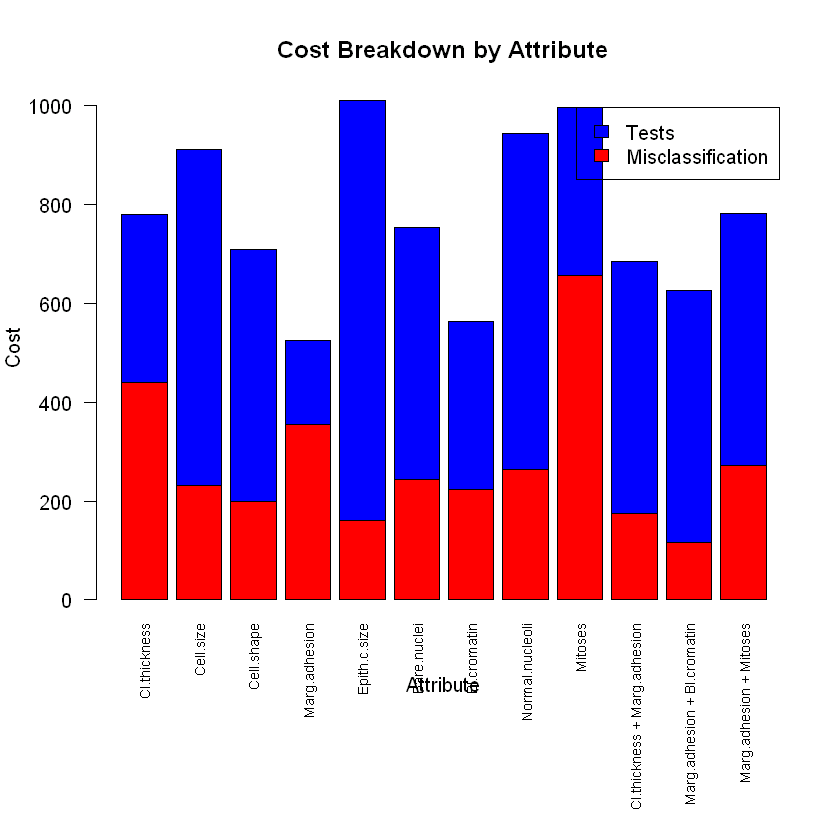

In [56]:
df <- data.frame(
    Id = 1:9,
    Attribute = sapply(1:9, function(i) names(BreastCancer)[i]),
    Errors_Cost = sapply(attrs_results, function(x) x$errors_cost),
    Tests_Cost = sapply(attrs_results, function(x) x$tests_cost)
)

combined_costs <- data.frame(
    Id = c(10, 11, 12),
    Attribute = c("Cl.thickness + Marg.adhesion", "Marg.adhesion + Bl.cromatin", "Marg.adhesion + Mitoses"),
    Errors_Cost = c(costs_1_4$errors_cost, costs_4_7$errors_cost, costs_4_9$errors_cost),
    Tests_Cost = c(costs_1_4$tests_cost, costs_4_7$tests_cost, costs_4_9$tests_cost)
)

df <- rbind(df, combined_costs)

cost_matrix <- t(as.matrix(df[, c("Errors_Cost", "Tests_Cost")]))

par(mar = c(10, 4, 4, 2))

# Stacked bar plot
barplot(cost_matrix, beside = FALSE, names.arg = df$Attribute, col = c("red", "blue"),
        main = "Cost Breakdown by Attribute", xlab = "Attribute", ylab = "Cost",
        legend.text = c("Misclassification", "Tests"), las = 2, cex.names = 0.7, ylim = c(0, max(cost_matrix) * 1.2))


## Part 2 - Trying to find the minimum for Tests Costs
Since the global minimum is accomplished using one attribute and the exercise also includes drawing a plot of cost of test vs misclassification I decided to find best model to minimize the misclassification costs
We'll accomplish this by sorting the models by their Errors Cost accuracy

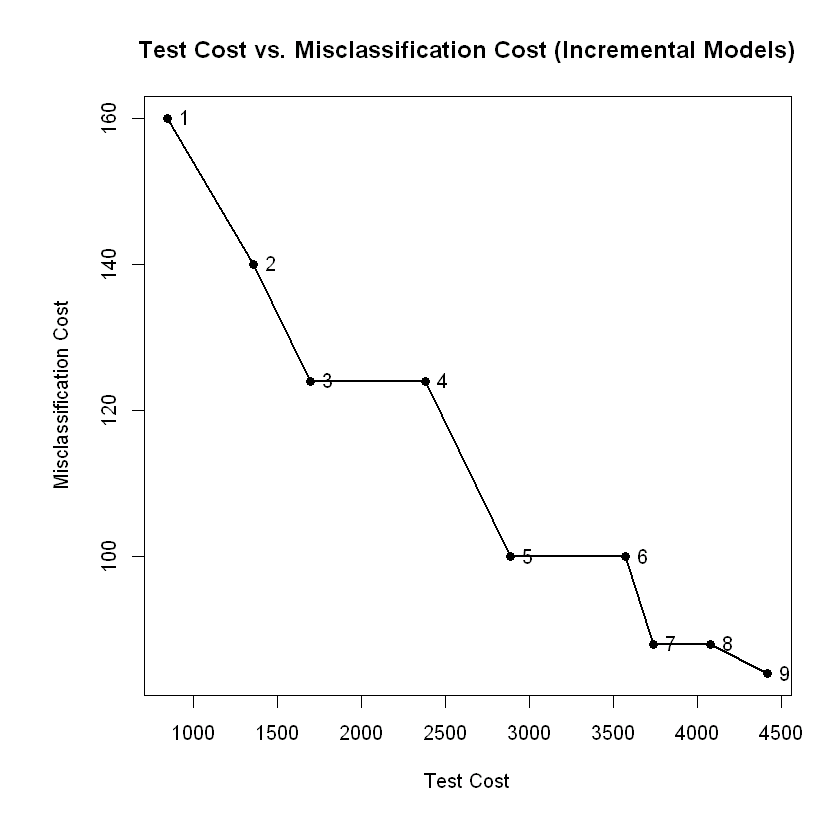

In [60]:
df <- data.frame(
    Id = 1:9,
    Attribute = sapply(1:9, function(i) names(BreastCancer)[i]),
    Errors_Cost = sapply(attrs_results, function(x) x$errors_cost),
    Tests_Cost = sapply(attrs_results, function(x) x$tests_cost),
    Total_Cost = sapply(attrs_results, function(x) x$total_cost)
)

df_best <- df[order(df$Errors_Cost), ]

cumulative_errors <- c()
cumulative_tests <- c()
attr_combinations <- list()

for (i in 1:9) {
    selected_attrs <- df_best$Id[1:i]
    attr_combinations[[i]] <- i
    
    costs <- get_costs(selected_attrs)
    
    cumulative_errors[i] <- costs$errors_cost
    cumulative_tests[i] <- costs$tests_cost
}

par(mar = c(6, 6, 4, 2))
plot(cumulative_tests, cumulative_errors, 
     xlab = "Test Cost", ylab = "Misclassification Cost", 
     main = "Test Cost vs. Misclassification Cost (Incremental Models)",
     type = "o", pch = 16, lwd = 2)

text(cumulative_tests, cumulative_errors, labels = attr_combinations, pos = 4, cex = 1)



This approach shows the tradeoff of tests costs when trying to achieve the lowest misclassification cost